# Import Library

In [117]:
# import library
from decouple import config
from sqlalchemy import null
import tweepy
import pandas as pd
import time
import json
from os.path import exists
import datetime
import matplotlib.pyplot as plt
import ast
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import html
import numpy as np

In [118]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [119]:
# import local functions ( Data Collecting )
from data_collecting.twitter_request import queryBuilding, TweetsReq, requestData, requestUserLocation, chunks

# Data Collecting

### Identify Topic and Keyword
Topic: War in Ukraine  
Keywords : Ukraine, Russia, war, invasion, conflict, Vladimir Putin, Volodymyr Zelenskyy, NATO, refugee, #RussianUkraineWar


In [120]:
# authentication
api_key = config('API_KEY')
api_key_secret = config('API_KEY_SECRET')
access_token = config('ACCESS_TOKEN')
access_token_secret = config('ACCESS_TOKEN_SECRET')
bearer_token = config('BEARER_TOKEN')

# authenticate
client = tweepy.Client(bearer_token=bearer_token)

In [121]:
# setting up columns header for data storage
columns = ['tweetId', 'author_id', 'tweet', 'lang', 'created_at']
tweet_fields = ['lang', 'created_at']
expansions = ['author_id']
curr_next_token = ''

### Data Pulling from Twitter API 

In [115]:
# building query (R)
query = queryBuilding('../input/demoInput.json')
print(f"This is used to do the request: \n {query}")

This is used to do the request: 
 (Ukraine OR Russia OR war OR invasion OR conflict OR Vladimir Putin OR Volodymyr Zelenskyy OR NATO OR refugee OR #RussianUkraineWar -RT) -is:retweet 


In [7]:
# request tweets data for the last 2 days (only up to 7 days)
startTime = '2022-03-11T00:00:00.00Z'
endTime = '2022-03-13T00:00:00.00Z'

requestData(client, query ,columns, tweet_fields, expansions, startTime, endTime, 100, 10000) 
print("Data Saved as raw_data.csv")

Data Saved as raw_data.csv


In [8]:
# request user data from raw_data.csv
df = pd.read_csv('raw_data.csv')
# cleaning up some messy stuff in raw data 
df = df.drop(df[df['author_id'] == "en"].index)
df = df.dropna()
batches = list(chunks(list(df['author_id']), 100))
tweetID_batches = list(chunks(list(df['tweetId']), 100))
loc_list = requestUserLocation(client, batches , tweetID_batches)
location_df = pd.DataFrame(loc_list)  
location_df.to_csv('location.csv')
print('Saved the location into location.csv')

Saved the location into location.csv


In [9]:
# merge tweets with users 
full_df = pd.merge(df, location_df , on="tweetId")
full_df.to_csv('raw_data_w_location.csv')
print("Saved as raw_data_w_location.csv")

Saved as raw_data_w_location.csv


In [122]:
# Example of Raw data (R)
full_df = pd.read_csv('raw_data_w_location.csv')
# clean some columns 
full_df = full_df.drop(["Unnamed: 0","author_id_y"], axis=1)
full_df = full_df.rename(columns={"author_id_x": "author_id"})
full_df.head()

,tweetId,author_id,tweet,lang,created_at,user_loc
0,1502796580189097984,899561089582727168,"@washingtonpost Well, here's a solution. Call ...",en,2022-03-12 23:59:59+00:00,same ol universe
1,1502796579861839877,1418378834769072132,"@ImPartEggplant Hamed, a 9 year old afghan chi...",en,2022-03-12 23:59:59+00:00,"Penistone, England"
2,1502796579819954177,1153991721971331074,"@DiegoFusaro Come la influencer que ""telegram ...",it,2022-03-12 23:59:59+00:00,NaN
3,1502796578951684099,1388518446233759747,@ZelenskyyUa @BorisJohnson @EmmanuelMacron @Ju...,en,2022-03-12 23:59:59+00:00,Canada
4,1502796578859454470,2617811454,I revised this handy #UkraineWar competency te...,en,2022-03-12 23:59:59+00:00,"In NYC, looking to escape"


# Data Cleaning

In [13]:
# basic cleaning - remove duplicates and null values
print(f"Before Remove Duplicate: {len(full_df)}")
full_df = full_df.drop_duplicates()
print(f"After Remove Duplicate: {len(full_df)}")
print(f'Before Removing Null (Mostly in User_loc): {len(full_df)}')
full_df = full_df.dropna(axis=0)
print(f'After Removing Null (Mostly in User_loc): {len(full_df)}')

Before Remove Duplicate: 10000
After Remove Duplicate: 10000
Before Removing Null (Mostly in User_loc): 10000
After Removing Null (Mostly in User_loc): 5730


In [14]:
stopwords = ["for", "on", "an", "a", "of", "and", "in", "the", "to", "from"]


def clean_tweet(tweet):
    temp = tweet.lower()
    temp = temp.replace('\n', ' ')
    temp = html.unescape(temp)
    temp = re.sub("'", "", temp) # to avoid removing contractions in english
    temp = re.sub("@[A-Za-z0-9_]+","", temp)  # removing handle 
    temp = re.sub("#[A-Za-z0-9_]+","", temp)  # removing hastags
    temp = re.sub(r'http\S+', '', temp) # removing any link
    temp = re.sub('[()!?]', ' ', temp)  # remove the punct 
    temp = re.sub('\[.*?\]',' ', temp)  # remove any weird symbol
    temp = re.sub("[^a-z0-9]"," ", temp) # remove any numbers
    temp = temp.split()
    temp = [w for w in temp if not w in stopwords] 
    temp = " ".join(word for word in temp)
    return temp

In [15]:
# Example of clean tweets
full_df['clean_tweet'] = [clean_tweet(tw) for tw in full_df['tweet']]
print(f"Before Cleaning:\n {full_df['tweet'][0]}")
print(f"After Cleaning:\n {full_df['clean_tweet'][0]}")

Before Cleaning:
 @washingtonpost Well, here's a solution. Call Zelensky and tell him he should accept Russia terms. Problem solved.
After Cleaning:
 well heres solution call zelensky tell him he should accept russia terms problem solved


In [16]:
# function to clean emoji and emoticont
def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

In [17]:
# Examples of weird locations
print(list(full_df['user_loc'].unique())[0:10])

['same ol universe', 'Penistone, England', 'Canada', 'In NYC, looking to escape', '🏄 Twitterverse', 'Indiana, USA', 'Murfreesboro, TN USA', 'Moscow Starbucks', 'Bucarest, Roumanie', 'UK']


In [19]:
# clean emoji, hastag, and link 
full_df['user_loc'] = full_df['user_loc'].apply(lambda row :deEmojify(row))
full_df = full_df[~full_df.user_loc.str.contains('#')] 
full_df['user_loc'] =full_df['user_loc'].apply(lambda x: re.sub(r'http\S+', '', x)) #return na value if list is empty
print(list(full_df['user_loc'].unique())[0:10])
print("Finished Cleaning the location data")

['same ol universe', 'Penistone, England', 'Canada', 'In NYC, looking to escape', ' Twitterverse', 'Indiana, USA', 'Murfreesboro, TN USA', 'Moscow Starbucks', 'Bucarest, Roumanie', 'UK']
Finished Cleaning the location data


In [20]:
# function to identify location
import spacy
nlp = spacy.load("en_core_web_sm")
def isLocation(doc):
    result = ''
    doc = nlp(doc)
    for ent in doc.ents:
        if ent.label_ == 'GPE':
            result = ent.text  
    return result

In [21]:
# entity extraction with spacy to only get country
full_df['extracted_user_loc'] = full_df['user_loc'].apply(lambda x: isLocation(x) if isLocation(x) else None) #return na value if list is empty
print("Finished Extracting the location")

In [23]:
# example of after the extraction
print(list(full_df['extracted_user_loc'].unique())[0:10])

[None, 'England', 'Canada', 'USA', 'Murfreesboro', 'Moscow', 'UK', 'Houston', 'Boston', 'MG']


In [24]:
print(f'Before cleaning null in extracted user loc: {len(full_df)}')
clean_df = full_df.dropna(axis=0)
print(f'After droping all the null in extracted user loc: {len(clean_df)}')

Before cleaning null in extracted user loc: 5704
After droping all the null in extracted user loc: 3364


In [25]:
clean_df[clean_df['extracted_user_loc'] == 'N.B.Canada'] = 'Canada'

/Users/kaixuanchin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/kaixuanchin/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1817: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [26]:
clean_df_copy = clean_df.copy()

In [ ]:
# use geo filtering to figure out the country
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import datetime
from geopy.exc import GeocoderTimedOut

geolocator = Nominatim(user_agent="my-app")
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1, max_retries=3)
for i, row in clean_df_copy.iterrows():
    try:
        temp = geocode( (clean_df_copy.loc[i,'extracted_user_loc']) , language='en')
        clean_df_copy.loc[i, 'latitute'] = temp.latitude
        clean_df_copy.loc[i, 'longitute'] = temp.longitude
        clean_df_copy.loc[i, 'country'] = temp[0].split(",")[-1]
        print(i)
    except:
        pass
print("finished all the location")


In [37]:
clean_df_copy.head()

,tweetId,author_id,tweet,lang,created_at,user_loc,clean_tweet,extracted_user_loc,location,latitute,longitute,country
1,1502796579861839877,1418378834769072132,"@ImPartEggplant Hamed, a 9 year old afghan chi...",en,2022-03-12 23:59:59+00:00,"Penistone, England",hamed 9 year old afghan child refugee arriving...,England,NaN,52.531021,-1.264906,United Kingdom
3,1502796578951684099,1388518446233759747,@ZelenskyyUa @BorisJohnson @EmmanuelMacron @Ju...,en,2022-03-12 23:59:59+00:00,Canada,you are artist pull all your game together you...,Canada,NaN,61.066692,-107.991707,Canada
8,1502796576690999297,744106700,Is it considered foreshadowing that Honeys hat...,en,2022-03-12 23:59:59+00:00,"Indiana, USA",is it considered foreshadowing that honeys hat...,USA,NaN,39.783730,-100.445882,United States
10,1502796575441141770,265489523,"If this is really going to happen, the human c...",en,2022-03-12 23:59:58+00:00,"Murfreesboro, TN USA",if this is really going happen human carnage u...,Murfreesboro,NaN,35.846040,-86.392110,United States
14,1502796574052818945,1100595818187374592,"@Holly__Storm @POTUS Russia will win, it’s ine...",en,2022-03-12 23:59:58+00:00,Moscow Starbucks,russia will win it s inevitable there s nothin...,Moscow,NaN,55.750446,37.617494,Russia


In [91]:
#saved clean data
clean_df = clean_df_copy
clean_df.to_csv('clean_data.csv', index=False)
print("Saved the clean data as clean_data.csv")

Saved the clean data as clean_data.csv


# Sentiment Analysis

In [123]:
# Example of the cleaned data (R)
clean_df = pd.read_csv('clean_data.csv')
clean_df.head()

,tweetId,author_id,tweet,lang,created_at,user_loc,clean_tweet,extracted_user_loc,location,latitute,longitute,country
0,1502796579861839877,1418378834769072132,"@ImPartEggplant Hamed, a 9 year old afghan chi...",en,2022-03-12 23:59:59+00:00,"Penistone, England",hamed 9 year old afghan child refugee arriving...,England,NaN,52.531021,-1.264906,United Kingdom
1,1502796578951684099,1388518446233759747,@ZelenskyyUa @BorisJohnson @EmmanuelMacron @Ju...,en,2022-03-12 23:59:59+00:00,Canada,you are artist pull all your game together you...,Canada,NaN,61.066692,-107.991707,Canada
2,1502796576690999297,744106700,Is it considered foreshadowing that Honeys hat...,en,2022-03-12 23:59:59+00:00,"Indiana, USA",is it considered foreshadowing that honeys hat...,USA,NaN,39.783730,-100.445882,United States
3,1502796575441141770,265489523,"If this is really going to happen, the human c...",en,2022-03-12 23:59:58+00:00,"Murfreesboro, TN USA",if this is really going happen human carnage u...,Murfreesboro,NaN,35.846040,-86.392110,United States
4,1502796574052818945,1100595818187374592,"@Holly__Storm @POTUS Russia will win, it’s ine...",en,2022-03-12 23:59:58+00:00,Moscow Starbucks,russia will win it s inevitable there s nothin...,Moscow,NaN,55.750446,37.617494,Russia


In [92]:
# get clean data filter out en
clean_df = pd.read_csv('clean_data.csv')
eng_df = clean_df[clean_df['lang'] == 'en']

In [ ]:
# put clean tweets to model and perform sentiment analysis 
from transformers import pipeline
import torch 
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import pandas as pd

# 0 - negative, 1- neutral, 2-positive


model_name = "cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

classifier = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)

# df = pd.read_csv('clean_data.csv')
tweet = eng_df['clean_tweet'].tolist()

res = classifier(tweet)

f=open('cardiffResult.txt','w')

for result in res:
    f.write(f'{result}\n')


In [93]:
# read cadiffNlp label from huggingface (R)
cardiff_label = []
cardiff_score = []
with open('cardiffResult.txt', 'r') as f:
    for line in f:
        line = line.strip()
        data = ast.literal_eval(line)
        if data.get('label') == 'LABEL_0': 
            label = 0
        elif data.get('label') == 'LABEL_1':
            label = 1 
        else:
            label = 2 
        cardiff_label.append(label)
        cardiff_score.append(data.get('score'))
print("Finished Reading Sentiment Analysis data")

Finished Reading Sentiment Analysis data


In [94]:
eng_df['cardiff_label'] = cardiff_label
eng_df['cardiff_score'] = cardiff_score

/Users/kaixuanchin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/kaixuanchin/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [95]:
# Example of after the sentiment analysis (R)
eng_df.head()

,tweetId,author_id,tweet,lang,created_at,user_loc,clean_tweet,extracted_user_loc,location,latitute,longitute,country,cardiff_label,cardiff_score
0,1502796579861839877,1418378834769072132,"@ImPartEggplant Hamed, a 9 year old afghan chi...",en,2022-03-12 23:59:59+00:00,"Penistone, England",hamed 9 year old afghan child refugee arriving...,England,NaN,52.531021,-1.264906,United Kingdom,1,0.548377
1,1502796578951684099,1388518446233759747,@ZelenskyyUa @BorisJohnson @EmmanuelMacron @Ju...,en,2022-03-12 23:59:59+00:00,Canada,you are artist pull all your game together you...,Canada,NaN,61.066692,-107.991707,Canada,0,0.573795
2,1502796576690999297,744106700,Is it considered foreshadowing that Honeys hat...,en,2022-03-12 23:59:59+00:00,"Indiana, USA",is it considered foreshadowing that honeys hat...,USA,NaN,39.783730,-100.445882,United States,1,0.829840
3,1502796575441141770,265489523,"If this is really going to happen, the human c...",en,2022-03-12 23:59:58+00:00,"Murfreesboro, TN USA",if this is really going happen human carnage u...,Murfreesboro,NaN,35.846040,-86.392110,United States,0,0.962232
4,1502796574052818945,1100595818187374592,"@Holly__Storm @POTUS Russia will win, it’s ine...",en,2022-03-12 23:59:58+00:00,Moscow Starbucks,russia will win it s inevitable there s nothin...,Moscow,NaN,55.750446,37.617494,Russia,0,0.445641


# Data Visualization

In [96]:
eng_df = eng_df.drop("location", axis=1)
eng_df = eng_df.dropna()

In [97]:
eng_df.head()

,tweetId,author_id,tweet,lang,created_at,user_loc,clean_tweet,extracted_user_loc,latitute,longitute,country,cardiff_label,cardiff_score
0,1502796579861839877,1418378834769072132,"@ImPartEggplant Hamed, a 9 year old afghan chi...",en,2022-03-12 23:59:59+00:00,"Penistone, England",hamed 9 year old afghan child refugee arriving...,England,52.531021,-1.264906,United Kingdom,1,0.548377
1,1502796578951684099,1388518446233759747,@ZelenskyyUa @BorisJohnson @EmmanuelMacron @Ju...,en,2022-03-12 23:59:59+00:00,Canada,you are artist pull all your game together you...,Canada,61.066692,-107.991707,Canada,0,0.573795
2,1502796576690999297,744106700,Is it considered foreshadowing that Honeys hat...,en,2022-03-12 23:59:59+00:00,"Indiana, USA",is it considered foreshadowing that honeys hat...,USA,39.783730,-100.445882,United States,1,0.829840
3,1502796575441141770,265489523,"If this is really going to happen, the human c...",en,2022-03-12 23:59:58+00:00,"Murfreesboro, TN USA",if this is really going happen human carnage u...,Murfreesboro,35.846040,-86.392110,United States,0,0.962232
4,1502796574052818945,1100595818187374592,"@Holly__Storm @POTUS Russia will win, it’s ine...",en,2022-03-12 23:59:58+00:00,Moscow Starbucks,russia will win it s inevitable there s nothin...,Moscow,55.750446,37.617494,Russia,0,0.445641


In [98]:
# cleaning up some word space 
eng_df['country']= eng_df['country'].apply(lambda x : x.strip() )

In [73]:
# setting for visualization

import seaborn as sns
import matplotlib.pyplot as plt

five_thirty_eight = [
    "#30a2da",
    "#fc4f30",
    "#e5ae38",
    "#6d904f",
    "#8b8b8b",
]

sns.set_palette(five_thirty_eight)
# sns.palplot(sns.color_palette())

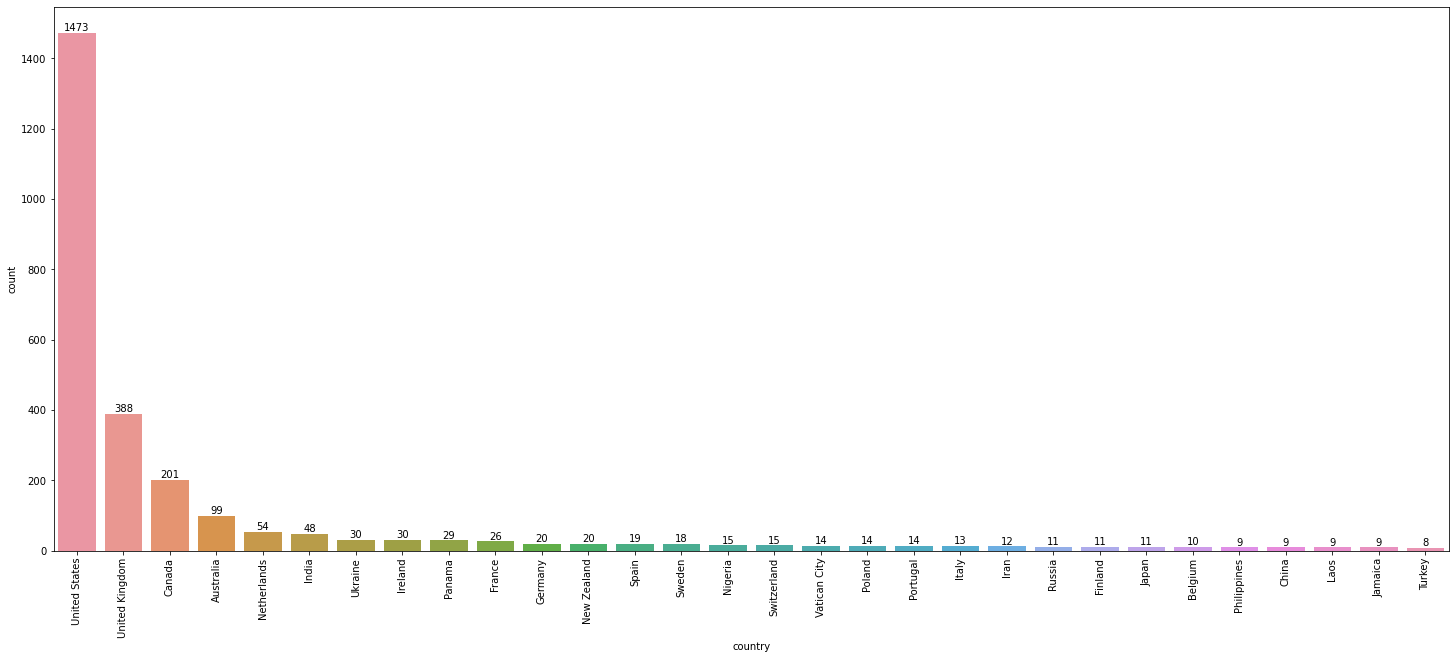

In [74]:
# distribution of tweets based on location
plt.figure(figsize=(25,10))
ax = sns.countplot(x="country", data=eng_df, order = eng_df['country'].value_counts().iloc[:30].index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
for container in ax.containers:
    ax.bar_label(container)
plt.show()
plt.close()

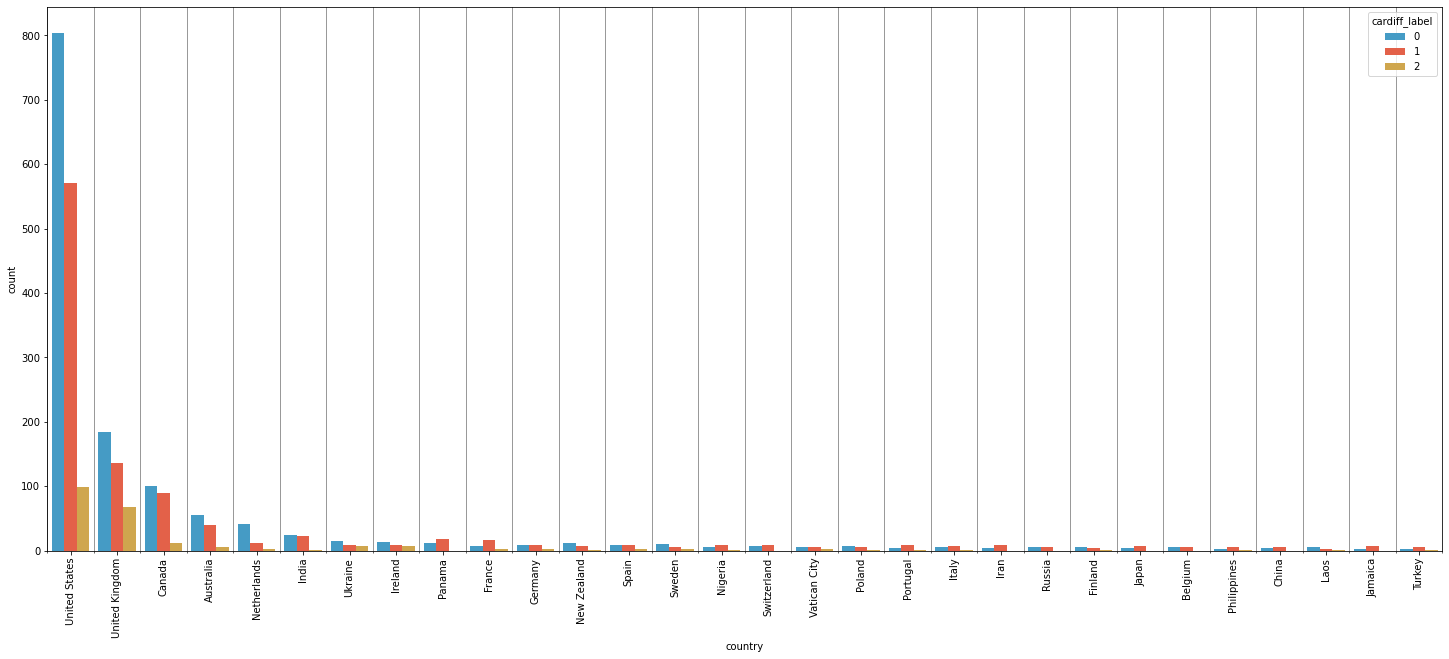

In [75]:
# breakdown of sentiment distibution
from matplotlib.ticker import MultipleLocator
plt.figure(figsize=(25,10))
ax = sns.countplot(x="country", hue="cardiff_label", data=eng_df, order = eng_df['country'].value_counts().iloc[:30].index)
ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
ax.xaxis.set_minor_locator(MultipleLocator(0.5))
ax.xaxis.grid(True, which='minor', color='grey')
plt.show()
plt.close()

In [99]:
# setting for maps visualization
import geopandas as gdp 
world = gdp.read_file(gdp.datasets.get_path('naturalearth_lowres'))

In [110]:
# prepare dataframe for maps visualization
result = eng_df.groupby(['country','cardiff_label']).size().reset_index(name='count') 
result.loc[result['country'] == "United States", 'country'] = "United States of America"
merged_df = pd.merge(world, result , left_on='name', right_on='country', how='left')
merged_df['cardiff_label'] = merged_df['cardiff_label'].fillna(0)
merged_df['count'] = merged_df['count'].fillna(0)

<AxesSubplot:>

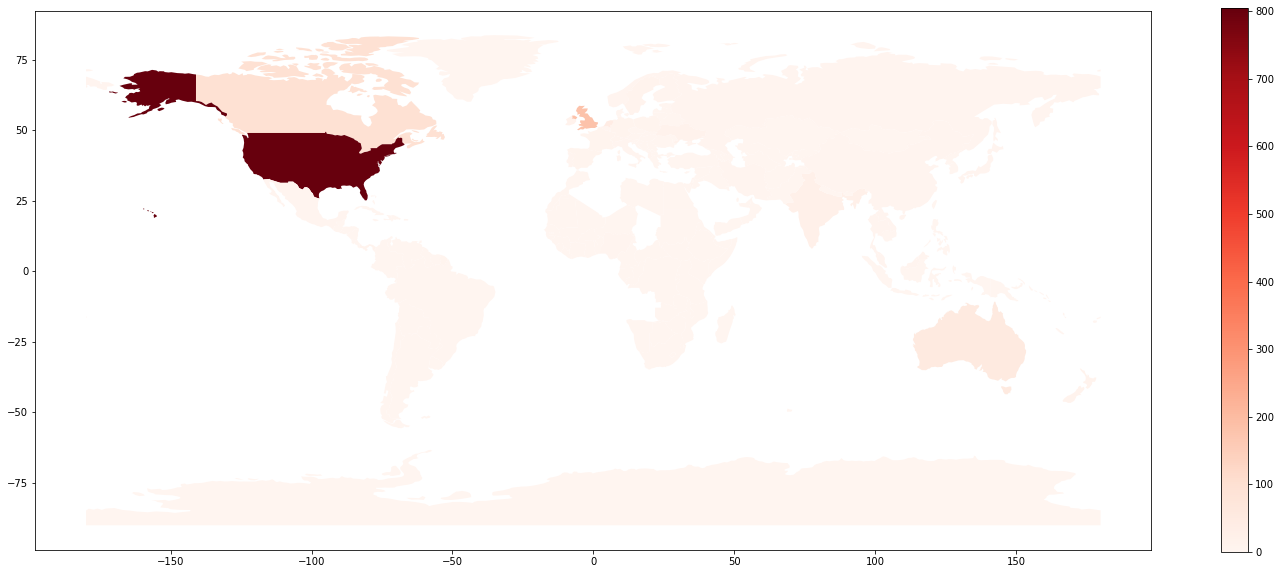

In [116]:
# negative world - 0 
neg_world = merged_df.loc[merged_df['cardiff_label'] == 0]
neg_world.plot(figsize=(25,10), column="count", legend=True, cmap='Reds')

<AxesSubplot:>

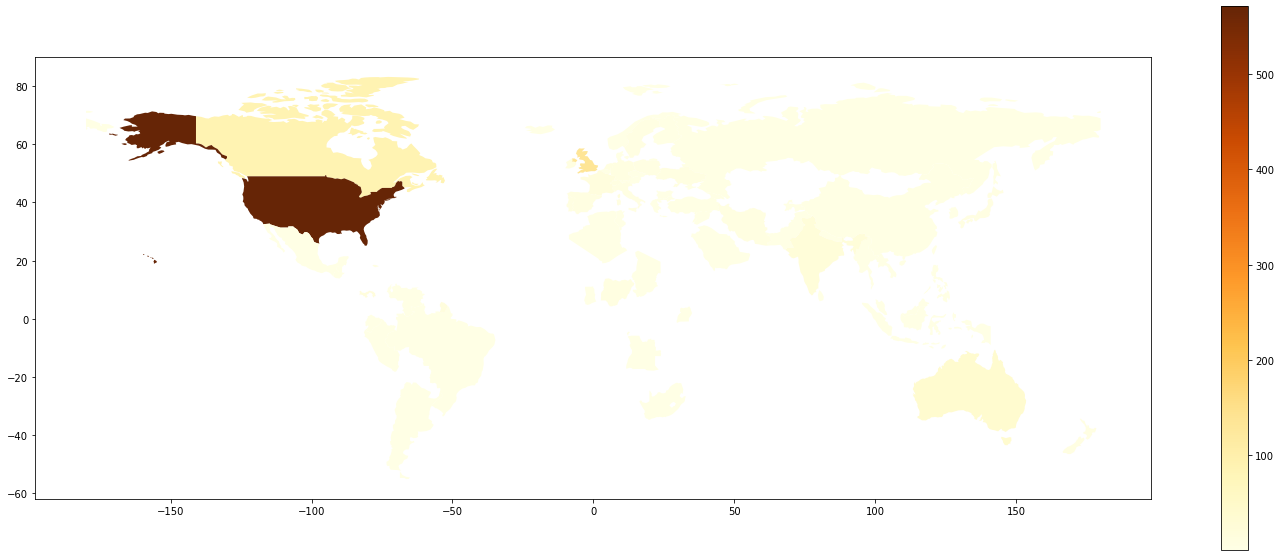

In [113]:
# neutral world - 1
neu_world = merged_df.loc[merged_df['cardiff_label'] == 1]
neu_world.plot(figsize=(25,10), column="count", legend=True, cmap='YlOrBr')

<AxesSubplot:>

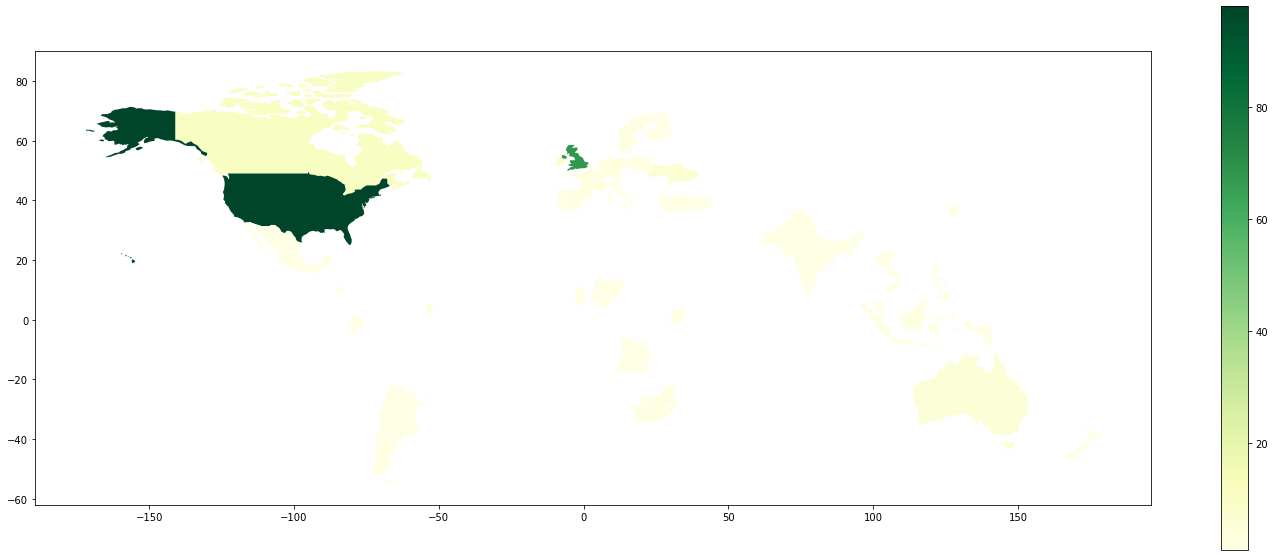

In [114]:
# postitive world - 2
pos_world = merged_df.loc[merged_df['cardiff_label'] == 2]
pos_world.plot(figsize=(25,10), column="count", legend=True, cmap='YlGn')